In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense , Dropout
from keras.callbacks import EarlyStopping
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

df = yf.download('EPOL')["Adj Close"].dropna()
print(df.isnull().sum())
print(df.tail())

[*********************100%***********************]  1 of 1 completed
0
Date
2023-10-11    18.139999
2023-10-12    17.760000
2023-10-13    17.910000
2023-10-16    19.260000
2023-10-17    19.830000
Name: Adj Close, dtype: float64


Here's we check for nulls to be sure, and view the data.

Values are prepare data to numpy array with shape (n_samples, n_features) like rows and columns in dataframe, MinMax set data from 0 to 1, thas is needed to normalize the data before training the LSTM model.

In [2]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values.reshape(-1, 1))

We are creating a sequence for 14 days...

In [3]:
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)
look_back = 14
X, y = create_dataset(data_scaled, look_back)

Train data will be used for model evaluation, and test later for find out if model forecast properly (non-trained data)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)

In [5]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 1), return_sequences=True))
model.add(Dropout(0.02))  # Add dropout to the first LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.02))  # Add dropout to the second LSTM layer
model.add(LSTM(128))
model.add(Dense(1))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 14, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 14, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 329,857
Trainable params: 329,857
Non-trai

In [7]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error', 'mean_squared_error'])

Callback is fiarly essential for overfitting in model to fast.

In [8]:
callback=[EarlyStopping(patience=10, restore_best_weights=True)]
history = model.fit(X_train, y_train, validation_split=0.3,callbacks=callback, epochs=200, batch_size=32, verbose=2)

Epoch 1/200
59/59 - 11s - loss: 0.0220 - mean_absolute_error: 0.0932 - mean_squared_error: 0.0220 - val_loss: 0.0022 - val_mean_absolute_error: 0.0350 - val_mean_squared_error: 0.0022 - 11s/epoch - 194ms/step
Epoch 2/200
59/59 - 3s - loss: 0.0022 - mean_absolute_error: 0.0360 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_absolute_error: 0.0342 - val_mean_squared_error: 0.0021 - 3s/epoch - 48ms/step
Epoch 3/200
59/59 - 3s - loss: 0.0021 - mean_absolute_error: 0.0358 - mean_squared_error: 0.0021 - val_loss: 0.0022 - val_mean_absolute_error: 0.0350 - val_mean_squared_error: 0.0022 - 3s/epoch - 49ms/step
Epoch 4/200
59/59 - 3s - loss: 0.0020 - mean_absolute_error: 0.0344 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_absolute_error: 0.0335 - val_mean_squared_error: 0.0019 - 3s/epoch - 44ms/step
Epoch 5/200
59/59 - 3s - loss: 0.0021 - mean_absolute_error: 0.0359 - mean_squared_error: 0.0021 - val_loss: 0.0038 - val_mean_absolute_error: 0.0489 - val_mean_squared_erro

In [9]:
pred_test = model.predict(X_test)

21/21 [==============================] - 2s 15ms/step


In [10]:
print(pred_test.shape)
print(y_test.shape)

(672, 1)
(672,)


Shape of data is correct, we only make shure passing them to inverse_transform with reshape(-1,1) method

In [11]:
predictions = scaler.inverse_transform(pred_test.reshape(-1, 1))
real_values = scaler.inverse_transform(y_test.reshape(-1, 1))

In [12]:
mae = mean_absolute_error(y_test, pred_test)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.014106773642512279


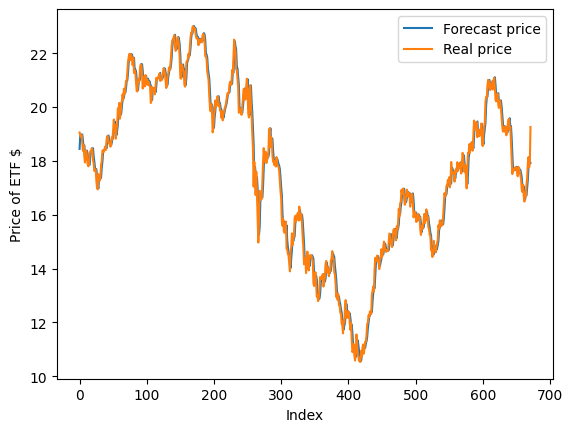

In [13]:

plt.plot(predictions, label='Forecast price')
plt.plot(real_values, label='Real price')
plt.xlabel('Index')
plt.ylabel('Price of ETF $')
plt.legend()
plt.show()

It's look gorgeous, isn't it? Data predict only 1 day ahead...

-You should ask so? We will be rich!!!


Somthing below explains everything...

In [16]:
predictions=predictions.flatten()
pct_change_y_test = (np.diff(y_test) / y_test[:-1]) * 100
pct_change_predictions = (np.diff(predictions) / predictions[:-1]) * 100
direction_correct = np.sign(pct_change_y_test) == np.sign(pct_change_predictions)
df = pd.DataFrame({
    'Real data': y_test[1:],  
    'Predicted price': predictions[1:],
    'Real data pct_change': pct_change_y_test,
    'Predicted price pct_change': pct_change_predictions,
    'Correct direction': direction_correct
})
# Show data with correct direction. Calc accurency..
print(df)
print("Accurency of direction: ", df["Correct direction"].sum()/len(df["Correct direction"]))

     Real data  Predicted price  Real data pct_change  \
0     0.455259        18.935350             -1.240074   
1     0.452141        18.988997             -0.684835   
2     0.455779        18.939920              0.804530   
3     0.439669        18.978819             -3.534506   
4     0.424080        18.757805             -3.545801   
..         ...              ...                   ...   
666   0.397906        17.275700              8.078402   
667   0.411425        17.761488              3.397539   
668   0.390877        18.093550             -4.994556   
669   0.398988        17.889673              2.075181   
670   0.471991        17.922483             18.296984   

     Predicted price pct_change  Correct direction  
0                      2.652111              False  
1                      0.283312              False  
2                     -0.258445              False  
3                      0.205378              False  
4                     -1.164530               True

C:\Users\Marcin\AppData\Local\Temp\ipykernel_5672\4057650305.py:2: RuntimeWarning: divide by zero encountered in divide
  pct_change_y_test = (np.diff(y_test) / y_test[:-1]) * 100


Accurency for only catching the direction is 48,43% for the X_Test sample (670 values) - like coin toss

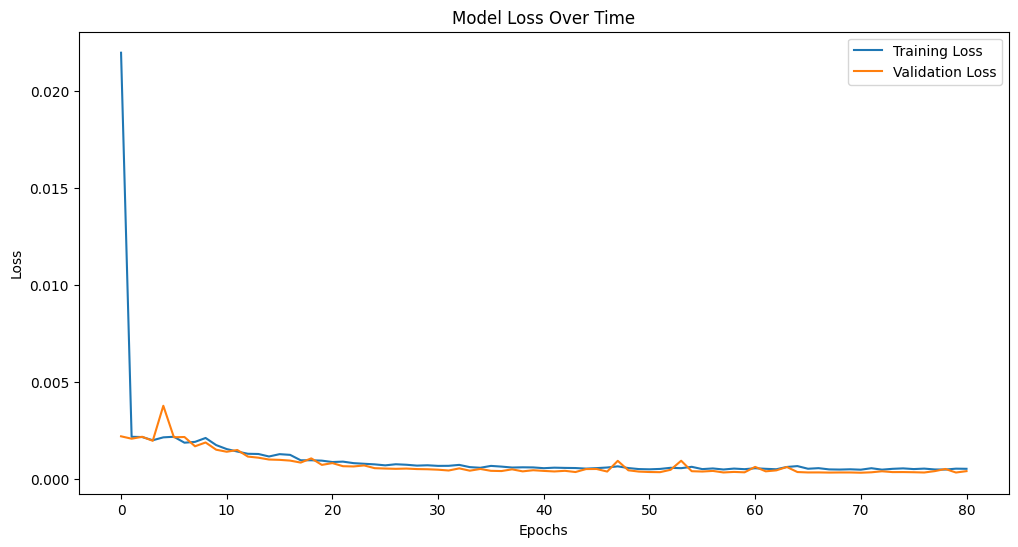

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Loss do not improve much over time

What for future?
I also will look at catching for more sequence days ahead, as:
- the model will tell me more or less something about the future of prices (maybe it's not wrong, it's just sometimes delayed?)